In [1]:
import sys
sys.version

'3.7.6 (default, Jan  8 2020, 13:42:34) \n[Clang 4.0.1 (tags/RELEASE_401/final)]'

In [2]:
import pandas as pd
pd.__version__

'0.24.2'

In [3]:
import sklearn
sklearn.__version__

'0.23.2'

In [4]:
import time
import itertools
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, plot_importance
import numpy as np
from numpy import sort
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from lightgbm import LGBMClassifier

In [5]:
# dataset path
dataset_path = './csv/diff_dataset.csv'
testset_path = './csv/diff_testset.csv'

In [6]:
# read dataset
dataset = pd.read_csv(dataset_path)
testset = pd.read_csv(testset_path)

In [7]:
# drop unnamed column
dataset.drop(columns=['Unnamed: 0'], inplace=True)
testset.drop(columns=['Unnamed: 0'], inplace=True)

In [8]:
# remove resolve state
data_drop_index = dataset[dataset['v_type_code'] %2 == 0].index.tolist()
dataset.drop(index=data_drop_index, axis=0, inplace=True)
test_drop_index = testset[testset['v_type_code'] %2 == 0].index.tolist()
testset.drop(index=test_drop_index, axis=0, inplace=True)

# data_57 = dataset[dataset['v_type_code'].isin([5,7])].index.tolist()
# dataset.drop(index=data_57, axis=0, inplace=True)

# test_57 = testset[testset['v_type_code'].isin([5,7])].index.tolist()
# testset.drop(index=test_57, axis=0, inplace=True)

In [9]:
# Try to combine 5 and 7 into one type.
dataset['v_type_code'] = dataset['v_type_code'].apply(lambda x: 57 if x == 5 or x == 7 else x)
testset['v_type_code'] = testset['v_type_code'].apply(lambda x: 57 if x == 5 or x == 7 else x)

In [10]:
print('dataset:')
print(dataset.shape)
print('testset:')
print(testset.shape)

column = dataset.columns

dataset:
(930, 997)
testset:
(840, 997)


In [11]:
X_train = dataset[column[:-1]]
X_test = testset[column[:-1]]
y_train = dataset[column[-1]]
y_test = testset[column[-1]]

X = pd.concat([X_train, X_test], axis=0, ignore_index=True, sort=False)
Y = pd.concat([y_train, y_test], axis=0, ignore_index=True, sort=False)
#     X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print(X.shape, Y.shape)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1770, 996) (1770,)
(930, 996) (930,)
(840, 996) (840,)


In [12]:
import re
X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '_', x))
X_test = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '_', x))

X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '_', x))

In [13]:
ss = StandardScaler()
std_X_train = ss.fit_transform(X_train)
std_X_test = ss.fit_transform(X_test)

In [14]:
# XGBoost
def xgboost(X_train, y_train, X_test, y_test, show=False, plt_show=True):
    last_time = time.time()
    xgb = XGBClassifier(n_estimators=100, objective='multi:softprob', num_class=5, random_state=0)
    xgb.fit(X_train, y_train)
    middle_time = time.time()
    y_pred = xgb.predict(X_test)
    current_time = time.time()
    accuracy_score(y_test, y_pred)

#     print("train time： {}".format(middle_time - last_time))
#     print("test time： {}".format(current_time - middle_time))
    if show:
        cm = confusion_matrix(y_test, y_pred)
        report=classification_report(y_test, y_pred, output_dict=True)
        report['train_time']=middle_time - last_time
        report['test_time']=current_time - middle_time
        return report

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red")
        # color="red" if cm[i, j] > thresh else "black")
    # plt.set_tight_layout(True)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [16]:
def xgboost_show_cm(X_train, y_train, X_test, y_test):
    last_time = time.time()
    xgb = XGBClassifier(num_class=5, random_state=0)
    xgb.fit(X_train, y_train)
    middle_time = time.time()

    y_pred = xgb.predict(X_test)

    current_time = time.time()

    print("XGBOOST Accuracy: %.2f" % accuracy_score(y_test, y_pred))
    print("train time： {}".format(middle_time - last_time))
    print("test time： {}".format(current_time - middle_time))
    cm = confusion_matrix(y_test, y_pred)
    print('confusion matrix xgb:')
    print(cm)
    print('classification report xgb:')
    print(classification_report(y_test, y_pred))

In [17]:
xgboost_show_cm(X_train, y_train, X_test, y_test)

XGBOOST Accuracy: 0.93
train time： 5.950835943222046
test time： 0.048280954360961914
confusion matrix xgb:
[[ 62   0   0   2   0]
 [  0  72   0   0   0]
 [  0   0 156   0   0]
 [  0   1   0 129  50]
 [  0   0   0   2 366]]
classification report xgb:
              precision    recall  f1-score   support

           1       1.00      0.97      0.98        64
           3       0.99      1.00      0.99        72
           9       1.00      1.00      1.00       156
          11       0.97      0.72      0.82       180
          57       0.88      0.99      0.93       368

    accuracy                           0.93       840
   macro avg       0.97      0.94      0.95       840
weighted avg       0.94      0.93      0.93       840



In [22]:
model = XGBClassifier(importance_type='gain',n_estimators=100)
model.fit(X, Y)
selection = SelectFromModel(model, threshold=0.0035, prefit=True)
select_X_train = selection.transform(X_train)
select_X_test = selection.transform(X_test)

In [23]:
xgboost_show_cm(select_X_train, y_train, select_X_test, y_test)

XGBOOST Accuracy: 0.94
train time： 0.3451061248779297
test time： 0.0037958621978759766
confusion matrix xgb:
[[ 64   0   0   0   0]
 [  0  72   0   0   0]
 [  0   0 156   0   0]
 [  0   1   0 127  52]
 [  0   0   0   0 368]]
classification report xgb:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        64
           3       0.99      1.00      0.99        72
           9       1.00      1.00      1.00       156
          11       1.00      0.71      0.83       180
          57       0.88      1.00      0.93       368

    accuracy                           0.94       840
   macro avg       0.97      0.94      0.95       840
weighted avg       0.94      0.94      0.93       840



# RF PCA 

In [ ]:
from sklearn.decomposition import PCA

In [43]:
pca=PCA(n_components=30)     #加载PCA算法，设置降维后主成分数目为自动
reduced_X=pca.fit_transform(X)#对样本进行降维


In [44]:
# random forest
def random_forest(X_train, y_train, X_test, y_test, show=False):
    last_time = time.time()
    rf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)

    rf.fit(X_train, y_train)
    middle_time = time.time()

    y_pred = rf.predict(X_test)

    current_time = time.time()

    print("Accuracy: %.2f"% accuracy_score(y_test, y_pred))

    print("训练耗时： {}".format(middle_time - last_time))
    print("测试耗时： {}".format(current_time - middle_time))
    if show:
        cm = confusion_matrix(y_test, y_pred)
        print('confusion matrix rf:')
        print(cm)
        print('classification report rf:')
        print(classification_report(y_test, y_pred))

        plot_confusion_matrix(cm, classes=['1', '3', '9', '11'],
                              normalize=True, title='Normalized confusion matrix')

        plt.show()

Accuracy: 0.79
训练耗时： 0.16594672203063965
测试耗时： 0.012247085571289062
confusion matrix rf:
[[ 63   0   0   2]
 [  8  78  35   0]
 [  1  18 158   2]
 [  1   4  40 110]]
classification report rf:
              precision    recall  f1-score   support

           1       0.86      0.97      0.91        65
           3       0.78      0.64      0.71       121
           9       0.68      0.88      0.77       179
          11       0.96      0.71      0.82       155

    accuracy                           0.79       520
   macro avg       0.82      0.80      0.80       520
weighted avg       0.81      0.79      0.79       520

Normalized confusion matrix
[[0.96923077 0.         0.         0.03076923]
 [0.0661157  0.6446281  0.2892562  0.        ]
 [0.00558659 0.10055866 0.88268156 0.01117318]
 [0.00645161 0.02580645 0.25806452 0.70967742]]


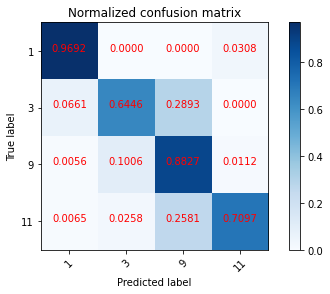

In [45]:
reduced_X_train, reduced_X_test, reduced_y_train, reduced_y_test = train_test_split(reduced_X, Y, test_size=0.7)
random_forest(reduced_X_train, reduced_y_train, reduced_X_test, reduced_y_test, show=True)

In [24]:
from lightgbm import LGBMClassifier

def gbm_show_cm(X_train, y_train, X_test, y_test):
    last_time = time.time()
    
    gbm = LGBMClassifier(learning_rate=0.1, n_estimators=40)
    gbm.fit(X_train, y_train)

    middle_time = time.time()

    y_pred = gbm.predict(X_test)

    current_time = time.time()

    print("GBM Accuracy: %.2f" % accuracy_score(y_test, y_pred))
    print("train time： {}".format(middle_time - last_time))
    print("test time： {}".format(current_time - middle_time))
    cm = confusion_matrix(y_test, y_pred)
    print('confusion matrix gbm:')
    print(cm)
    print('classification report gbm:')
    print(classification_report(y_test, y_pred))
    # 特征重要度
#     print('Feature importances:', list(gbm.feature_importances_))
    
    # 网格搜索，参数优化 learning_rate=0.1, n_estimators=40
#     estimator = LGBMClassifier(num_leaves=31)
#     param_grid = {
#         'learning_rate': [0.01, 0.1, 1],
#         'n_estimators': [20, 40]
#     }
#     gbm = GridSearchCV(estimator, param_grid)
#     gbm.fit(X_train, y_train)
#     print('Best parameters found by grid search are:', gbm.best_params_)
    


In [25]:
gbm_show_cm(X_train, y_train, X_test, y_test)

GBM Accuracy: 0.93
train time： 2.3554527759552
test time： 0.16838812828063965
confusion matrix gbm:
[[ 64   0   0   0   0]
 [  0  70   0   0   2]
 [  0   0 156   0   0]
 [  0   1   0 126  53]
 [  0   0   0   0 368]]
classification report gbm:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        64
           3       0.99      0.97      0.98        72
           9       1.00      1.00      1.00       156
          11       1.00      0.70      0.82       180
          57       0.87      1.00      0.93       368

    accuracy                           0.93       840
   macro avg       0.97      0.93      0.95       840
weighted avg       0.94      0.93      0.93       840



In [26]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingClassifier
import numpy as np

xgb = XGBClassifier()
lgbm = LGBMClassifier()
rf = RandomForestClassifier()


lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[xgb, lgbm, rf], 
                          use_probas=True,
                          average_probas=False,
                          meta_classifier=lr)

In [34]:
for clf, label in zip([xgb, lgbm, rf, sclf], 
                      ['XGB', 
                       'LGB', 
                       'RF',
                       'StackingClassifier']):
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("[%s] Accuracy: %.3f" % (label, accuracy_score(y_test, y_pred)))

[XGB] Accuracy: 0.936
[LGB] Accuracy: 0.937
[RF] Accuracy: 0.913
[StackingClassifier] Accuracy: 0.938


In [28]:
im=pd.DataFrame({'importance':model.feature_importances_,'var':X.columns})
im=im.sort_values(by='importance',ascending=False)

In [29]:
all_columns = X_train.columns
xgb_columns = im[0:57]['var'].values

In [30]:
from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import make_pipeline

xgb = make_pipeline(ColumnSelector(xgb_columns),
                      XGBClassifier())

sclf = StackingClassifier(classifiers=[xgb, lgbm, rf], 
                          use_probas=True,
                          average_probas=False,
                          meta_classifier=lr)


In [31]:
for clf, label in zip([xgb, lgbm, rf, sclf], 
                      ['XGB', 
                       'LGB', 
                       'RF',
                       'StackingClassifier']):
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("[%s] Accuracy: %.2f" % (label, accuracy_score(y_test, y_pred)))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

[XGB] Accuracy: 0.94
[[ 64   0   0   0   0]
 [  0  72   0   0   0]
 [  0   0 156   0   0]
 [  0   1   0 126  53]
 [  0   0   0   0 368]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        64
           3       0.99      1.00      0.99        72
           9       1.00      1.00      1.00       156
          11       1.00      0.70      0.82       180
          57       0.87      1.00      0.93       368

    accuracy                           0.94       840
   macro avg       0.97      0.94      0.95       840
weighted avg       0.94      0.94      0.93       840

[LGB] Accuracy: 0.94
[[ 64   0   0   0   0]
 [  0  71   0   0   1]
 [  0   0 156   0   0]
 [  0   0   0 128  52]
 [  0   0   0   0 368]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        64
           3       1.00      0.99      0.99        72
           9       1.00      1.00      1.00       156
          11       1

In [32]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

class AveragingModelsMini(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)
 
        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)  

In [33]:
averaged_models = AveragingModelsMini(models = (xgb, lgbm, rf, sclf))